Consider a SVF with the following structure:

```
              +--> H         +--> B
              |              |                      
X ---> (+) ---+---> (k/s) ---+---> (c^2*k/s) ---+---> L
        ^-                   |                  |
        |                    V                  |
        |                  (2rc)                |
        |                    |                  |
        |                    V                  |
        +------------------ (+) <---------------+
        
```

1 solution(s) found:


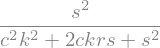

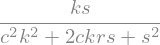

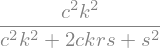

In [19]:
from sympy import *
from IPython.display import display, Latex
from ipywidgets.widgets import interact, FloatSlider as slider, Checkbox as checkbox

init_printing()

var('H B L X s')
r = Symbol('r', real=True)
c = Symbol('c', positive=True)
k = Symbol('k', positive=True)

tfs = solve([
    H - ( X - (2*r*c*B + L) ),
    B - ( H*k/s ),
    L - ( B*c*c*k/s ) ], H, B, L, dict=True)
print('{} solution(s) found:'.format(len(tfs)))
H = tfs[0][H]/X
B = tfs[0][B]/X
L = tfs[0][L]/X

#display(Latex("$$ \\frac H X = " + latex(H) + " $$"))
#display(Latex("$$ \\frac B X = " + latex(B) + " $$"))
#display(Latex("$$ \\frac L X = " + latex(L) + " $$"))
display(H)
display(B)
display(L)


There's a couple of different ways to define the cutoff frequency of this filter, but let's choose the resonant peak of the band-pass filter.

In [2]:
omega_c = Symbol('omega_c', positive=True)
solns = solve(
    re(diff(B.subs(s, omega_c*I), omega_c)),
    omega_c, dict=True)
assert(len(solns) == 1)
omega_c = solns[0][omega_c]

display(Latex("$$ \\omega_c = " + latex(omega_c) + " $$"))


<IPython.core.display.Latex object>

Let's redefine our filter then, replacing the constant $k$ with the equivalent in terms of the cutoff frequency, $\omega_c / c$:

In [3]:
omega_c = Symbol('omega_c', positive=True)
H = H.subs(k, omega_c/c)
B = B.subs(k, omega_c/c)
L = L.subs(k, omega_c/c)

display(Latex("$$ \\frac H X = " + latex(H) + " $$"))
display(Latex("$$ \\frac B X = " + latex(B) + " $$"))
display(Latex("$$ \\frac L X = " + latex(L) + " $$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The denominator for all three outputs is the same (except for a constant multiple on the band pass output), so they will have the same poles:

In [6]:
poles = solve(denom(L), s)
display(Latex('$$' + latex(poles[0]) + ' \\newline ' + latex(poles[1]) + '$$'))
print('So:')
display(Latex('$$' + latex(s) + "= - \\omega_c (r \\pm \\sqrt {r^2-1}) $$"))


<IPython.core.display.Latex object>

So:


<IPython.core.display.Latex object>

The stability criterion here is that the real portion of the root is negative.  There are a few cases to consider:

   - $|r| \ge 1$, in which case $r^2 - 1$ is a positive real number and the radical is smaller than $|r|$.
       * If r is positive, then there are two real poles, and both are negative (stable)
       * If r is negative, then there are two real poles, and both are positive (unstable)
   - $|r| \le 1$, in which case the radical has imaginary value and there are poles at $-\omega_c (r \pm i \sqrt {1 - r^2})$
       * If $r \ne 0$, the real portion has sign opposite r (stable iff $r > 0$)
       * If $r = 0$, these two poles lie on the imaginary axis (marginal)
       
Therefore, the filter is stable if $r > 0$, and will self-oscillate if $r = 0$.

Below is the frequency response of the filter:

In [7]:
def mag2db(x):
    return 20*log(x, 10)

#def plot_tf(tf, var, domain=(1, 1e6), **kwargs):
#    tf = tf.substitute({var:var*i})
#    return plot_semilogx(mag2db(abs(tf)), (var, domain[0], domain[1]), base=2, **kwargs)

def log_transform(func, var, domain, base):
    return (func.subs({var:base**var}), (log(domain[0], base), log(domain[1], base)))

def plot_tf(tf, var, disp_slope=False, domain=(250, 1e6), log_xfm=True, rng=(-40, 15), **kwargs):
    tf = tf.subs({var:var*I})
    if log_xfm:
        (tf, domain) = log_transform(tf, var, domain, 2)
    domain = (var, domain[0], domain[1])
    slope = diff(mag2db(abs(tf)), var)
    m = plotting.plot(mag2db(abs(tf)), domain, ymin=rng[0], ymax=rng[1], plot_points=50, show=False, **kwargs)
    if disp_slope:
        m.extend(plotting.plot(slope, domain, plot_points=20, linestyle='--', show=False, **kwargs))
    p = plotting.plot(arg(tf), domain, ymin=-pi, ymax=pi, plot_points=20, show=False, **kwargs)
    return (m, p)
    
@interact
def _(f=slider(min=0, max=20000, step=500, value=2000, description='$f_c$'),
      R=slider(min=0, max=5, value=1, step=0.2),
      C=slider(min=0, max=10, value=1, step=0.2),
      show_derivs=checkbox(value=False, description='Show Filter Slope')):
    w=2*pi*f
    l = L.subs({omega_c: w, r: R, c: C})
    b = B.subs({omega_c: w, r: R, c: C})
    h = H.subs({omega_c: w, r: R, c: C})
    lp = plot_tf(l, s, show_derivs, color='blue')
    bp = plot_tf(b, s, show_derivs, color='red')
    hp = plot_tf(h, s, show_derivs, color='green')
    lp[0].extend(bp[0])
    lp[0].extend(hp[0])
    lp[1].extend(bp[1])
    lp[1].extend(hp[1])
    lp[0].show()
    lp[1].show()

interactive(children=(FloatSlider(value=2000.0, description='$f_c$', max=20000.0, step=500.0), FloatSlider(val…

Notice that R controls the resonance of the filter, while C acts purely as an inverse gain control to the band pass filter and does not affect the low pass or high pass performance.  For larger values of R (less resonance), the band pass filter acts like a single EQ, with width controlled by R and gain by C.

Now let's look at the different sum filters (notch, high cut, low cut):

In [8]:
@interact
def _(f=slider(min=0, max=20000, step=500, value=2000, label='$f_c$'),
      R=slider(min=0, max=5, value=1, step=0.2),
      C=slider(min=0, max=10, value=1, step=0.2),
      show_derivs=checkbox(value=False, label='Show Filter Slope')):
    w=2*pi*f
    hi_cut = (L+B).subs({omega_c:w, r:R, c:C})
    lo_cut = (B+H).subs({omega_c:w, r:R, c:C})
    notch = (L+H).subs({omega_c:w, r:R, c:C})
    hc = plot_tf(hi_cut, s, show_derivs, color='blue')
    nh = plot_tf(notch, s, show_derivs, color='red')
    lc = plot_tf(lo_cut, s, show_derivs, color='green')
    hc[0].extend(nh[0])
    hc[0].extend(lc[0])
    hc[1].extend(nh[1])
    hc[1].extend(lc[1])
    hc[0].show()
    hc[1].show()

interactive(children=(FloatSlider(value=2000.0, description='f', max=20000.0, step=500.0), FloatSlider(value=1…

One interesting thing to note here is that the performance of the notch filter is quite good.  Though both the low pass and high pass filters only provide ~6dB of attenuation here (neglecting resonance), they have nearly total rejection at the cutoff frequency because when added together their signals are out of phase.  Also of note is that the C parameter now acts similarly (qualitatively, if not physically) to the response usually associated with a "resonance" knob for the low/hi cut filters.

At this point, we're going to fix c at 1.  We'll apply the bilinear transform to turn our continuous time model into a discrete time model, and make the substitution:
$$ \omega_d = \frac {\omega_c T_s} 2 $$

In [9]:
t = Symbol('t', positive=True)
var('z_i t omega_d') # note - z_i = z^-1.  This makes the computer algebra easier
bilinear = (2/t)*(1-z_i)/(1+z_i)
Lz = L.subs({s:bilinear, omega_c: 2*omega_d/t}).cancel().collect(z_i)
Bz = B.subs({s:bilinear, omega_c: 2*omega_d/t}).cancel().collect(z_i)
Hz = H.subs({s:bilinear, omega_c: 2*omega_d/t}).cancel().collect(z_i)
display(Latex("$$ \\frac L Z = " + latex(Lz) + "$$"))
display(Latex("$$ \\frac B Z = " + latex(Bz) + "$$"))
display(Latex("$$ \\frac H Z = " + latex(Hz) + "$$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
#TODO: Have to fix this cell for sympy instead of sage

def plot_ztf(tf, var, samp_time, domain=None, rng=(-40, 15), **kwargs):
    if domain is None:
        domain = (250, pi/samp_time)
    tf = tf.subs({var:E**(-I*var*samp_time)})
    (tf, domain) = log_transform(tf, var, domain, 2)
    domain = (var, domain[0], domain[1])
    p = plotting.plot(mag2db(abs(tf)), domain, ymin=rng[0], ymax=rng[1], plot_points=50, **kwargs)
    p2 = plotting.plot(arg(tf), domain, ymin=-pi, ymax=pi, plot_points=20, **kwargs)
    return (p, p2)
    
@interact
def _(f=slider(min=0, max=20000, step=500, value=2000, description='$f_c$'),
      R=slider(min=0, max=5, value=1, step=0.2),
      C=slider(min=0, max=10, value=1, step=0.2),
      show_analog=checkbox(value=False, description='Show Analog')):
    Ts = 1/44100
    w=2*pi*f
    w_d=w*Ts/2
    l = Lz.subs({omega_d: w_d, r: R, c: C, t: Ts})
    b = Bz.subs({omega_d: w_d, r: R, c: C, t: Ts})
    h = Hz.subs({omega_d: w_d, r: R, c: C, t: Ts})
    (m, p) = plot_ztf(l, z_i, Ts, color='blue')
    (m2, p2) = plot_ztf(b, z_i, Ts, color='red')
    (m3, p3) = plot_ztf(h, z_i, Ts, color='green')
    m.extend(m2)
    m.extend(m3)
    p.extend(p2)
    p.extend(p3)
    
    if show_analog:
        domain = (250, pi/Ts)
        l = L.subs({omega_c: w, r: R, c: C})
        b = B.subs({omega_c: w, r: R, c: C})
        h = H.subs({omega_c: w, r: R, c: C})
        (m1, p1) = plot_tf(l, s, domain=domain, linestyle='--', color='blue')
        (m2, p2) = plot_tf(b, s, domain=domain, linestyle='--', color='red')
        (m3, p3) = plot_tf(h, s, domain=domain, linestyle='--', color='green')
        m.extend(m1)
        m.extend(m2)
        m.extend(m3)
        p.extend(p1)
        p.extend(p2)
        p.extend(p3)
    m.show()
    p.show()

interactive(children=(FloatSlider(value=2000.0, description='$f_c$', max=20000.0, step=500.0), FloatSlider(val…

Notice that for low values of the cutoff frequency the z transformed filter is accurate, but as $f_c$ approaches $f_s/2$ it becomes less and less accurate (set, for example, cutoff to to 15k and R to 0.2).  This is because the bilinear transform non-linearly warps the frequency space when it transforms the interval $(0, f_s)$ into $(0, \pi)$.  We help fix this issue by "pre-warping" the cutoff frequency to compensate.  This has the effect of steepening the frequency response curves as the frequency approaches half the sample rate, but allows for cutoff frequency matching, as shown in the band pass filter:

In [13]:
#TODO: Have to fix this cell for sympy instead of sage

@interact
def _(f=slider(4000, 20000, step_size=500, default=14000, label='$f_c$'),
      R=slider(0, 1, default=0.2, step_size=0.1)):
    w=2*pi*f # cutoff frequency 14kHz
    Ts = 1/44100 # sample rate 44.1kHz
    w_d = w*Ts/2
    domain=(1e4, pi/Ts)
    b_uncompensated = Bz.substitute(omega_d=w_d, r=R, c=1, t=Ts)
    b_compensated = Bz.substitute(omega_d=tan(w_d), r=R, c=1, t=Ts)
    b_analog = B.substitute(omega_c=w, r=R, c=1)
    (m, p) = plot_ztf(b_uncompensated, z_i, Ts, domain=domain)
    (m, p) = add_tuples((m, p), plot_ztf(b_compensated, z_i, Ts, domain=domain, linestyle=':'))
    (m, p) = add_tuples((m, p), plot_tf(b_analog, s, domain=domain, linestyle='--'))
    g = graphics_array((m, p), ncols=1)
    g.show()

Interactive function <function _ at 0x7f3be87eb550> with 2 widgets
  f: TransformIntSlider(value=14000, min=40…

Now, we can apply the prewarp to the transfer function in Z space:

In [8]:
Lz_pw = Lz.subs(omega_d, tan(omega_d))
Bz_pw = Bz.subs(omega_d, tan(omega_d))
Hz_pw = Hz.subs(omega_d, tan(omega_d))
#pretty_print(LatexExpr("\\frac L Z = ") + latex(Lz_pw))
#pretty_print(LatexExpr("\\frac B Z = ") + latex(Bz_pw))
#pretty_print(LatexExpr("\\frac H Z = ") + latex(Hz_pw))

Finally, we manipulate the transfer function into the form:

$$ F = \frac {\sum_{k=0}^N {B_k z^{-k}}} {1 - \sum_{k=1}^M {A_k z^{-k}}} $$

And therefore we can write, in the z domain:

$$ F(z) = \sum_{k=0}^N {B_k X(z) z^{-k}} + \sum_{k=1}^M {A_k F(z) z^{-k}} $$



In [11]:
def bilinear_to_sequence(F, var, Fvar, Xvar):
    F_a = denom(F).as_poly(var).all_coeffs()[::-1]
    scalar = F_a[0]
    F_a = [-x for x in F_a[1:]]
    F_b = [x for x in numer(F).as_poly(var).all_coeffs()[::-1]]
    return ((1/scalar)*(sum(F_b[k]*Xvar*var**k for k in range(len(F_b)))
                              + sum(F_a[k]*Fvar*var**(k+1) for k in range(len(F_a)))))

z = var('z')
omega_p = var('omega_p')
L_z = var('L_z')
B_z = var('B_z')
H_z = var('H_z')

L_exp = bilinear_to_sequence(Lz, z_i, L_z, X).subs({omega_d: omega_p})
B_exp = bilinear_to_sequence(Bz, z_i, B_z, X).subs({c: 1, omega_d: omega_p})
H_exp = bilinear_to_sequence(Hz, z_i, H_z, X).subs({omega_d: omega_p})

display(Latex("$$ L_z = "+ latex(L_exp) +"$$"))
display(Latex("$$ B_z = "+ latex(B_exp) +"$$"))
display(Latex("$$ H_z = "+ latex(H_exp) +"$$"))
display(Latex("$$ \\mathrm{Where} \\: " + latex(omega_p) + ' = ' + latex(tan(omega_d)) + "$$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>